<a href="https://colab.research.google.com/github/Alejandro-ZZ/Machine-Learning-UNS/blob/master/4_Classifiers_cancer_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Diagnóstico de cáncer**

En el siguiente notebook se desarrolla un **clasificador** que permita **predecir la benignidad o malignidad de un tumor**.
<br><br>
Se utiliza el dataset **Winsconsin Breast Cancer**, el cual contiene una tabla con **569 datos de histología mamaria humana**, 357 casos de tejido tumoral benigno y 212 tejido maligno.
<br><br>
Se evaluarán distintos clasificadores y la combinación de algunos de sus hiperparámetros por medio de la función **GridSearchCV**. Así mismo, se realiza una **reducción de dimensionalidad** en los atributos para ver el comportamiento de los modelos y si estos mejoran respecto a la totalidad de los mismos.

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

## **1. Lectura y análisis del dataset**

La lectura se realiza de un repositorio donde se encuentra el dataset para propósitos educativos. Sin embargo, el dataset completo se puede encontrar en [kaggle.com](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data)

In [ ]:
cancer_tissues = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectBCD/data/data.csv")
cancer_tissues.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


Se observa un resumen del dataset para conocer aspectos como los tipos de datos de las columnas y la cantidad de valores nulos.

In [ ]:
cancer_tissues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

- Se observa que todos los atributos son numéricos a excepción de ***diagnosis*** (este será el target del modelo)
- La única columna que presenta datos sin registrar es ***Unnamed: 32*** que no aporta información alguna
- La columna ***id*** es el identificador único del paciente, se puede omitir para el modelo

Se procede a extraer el target (y) y los atributos (X)

In [ ]:
# Se elimina la columna 'id' y 'Unnamed: 32'
cancer_tissues = cancer_tissues.drop(columns=['id', 'Unnamed: 32'])

#Se codifica el diagnóstico a valores numéricos
le = LabelEncoder()
cancer_tissues['diagnosis'] = le.fit_transform(cancer_tissues['diagnosis'])

# Se extraen los atributos (features) y diagnostico
X = cancer_tissues.drop(columns='diagnosis')
y = cancer_tissues['diagnosis']

# Se obtienen los atributos estandarizados
scaler = StandardScaler()
scaler.fit(X)
X_norm = pd.DataFrame(scaler.transform(X), columns=X.columns)

## **2. Evaluación de modelos**

Se evalúan diferentes modelos para todos los atributos y los mismos estandarizados.

Primero se definen los modelos e hiperparámetros.

In [ ]:
# Modelos e hiperparámetros a evaluar
model_params = {
    'K-nearest neighbors':{
        'model': KNeighborsClassifier(),
        'params':{
            'n_neighbors': [n for n in range(2,90,2)]
        }
    },
    'SVM': {
        'model': SVC(random_state=4),
        'params': {
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'C': [0.1, 1, 10]
        }
    },
    'Logistic Regression':{
        'model': LogisticRegression(tol=1e-2, random_state=4),
        'params':{
            'solver': ['liblinear', 'newton-cg'],
            'C': [0.1, 1, 10]
        }
    },
    'Random Forest':{
        'model': RandomForestClassifier(random_state=4),
        'params':{
            'n_estimators': [n for n in range(10,100,10)],
            'criterion':['gini','entropy'],
        }
    }
}

# Proporción de separación para entrenamiento y prueba
data_split = np.arange(0.2, 0.8, 0.1)

Ahora se evalúa cada modelo y su respectiva combinación de hiperparámetros para cada dataset

In [ ]:
data_results = {}
datasets = {'X': X, 'X norm': X_norm}

for dataset in datasets:
  results = []
  feats = datasets[dataset]
  for size in data_split:
    
    X_train, X_test, y_train, y_test = train_test_split(feats, y, test_size = size, random_state=4)

    model = []
    grid_score = []
    cross_score = []
    params = []

    for model_name, values in model_params.items():
      clf = GridSearchCV(values['model'], values['params'], cv=5)
      clf.fit(X_train, y_train)
      
      #test_score = cross_validate(clf.best_estimator_, X_test, y_test, scoring='accuracy', cv = 5)

      model.append(model_name)
      grid_score.append(clf.best_score_)
      #cross_score.append(np.mean(test_score['test_score']))
      cross_score.append(clf.score(X_test, y_test))
      params.append(clf.best_params_)

    dummy_df = pd.DataFrame({'Modelo': model, 'Train score': grid_score,
                            'Test score': cross_score, 'Parametros': params})
    dummy_df['Test split'] = np.round(size, 1)

    # Guarda los resultados para el Split respectivo
    results.append(dummy_df)

  # Resultados para el dataset respectivo
  data_results[dataset] = pd.concat([data for data in results ]).reset_index().drop('index', axis=1)

### **2.1. Datos no modificados (X)**

Se analizan los resultados para los atributos sin modificar

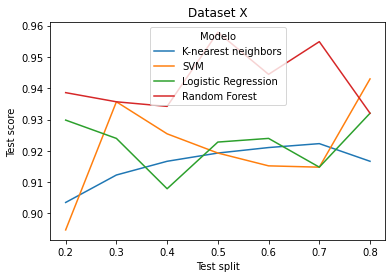


El mejor modelo es Random Forest con un puntaje de prueba de 0.9579




,Modelo,Train score,Test score,Parametros,Test split
15,Random Forest,0.954135,0.957895,"{'criterion': 'entropy', 'n_estimators': 10}",0.5
23,Random Forest,0.958824,0.954887,"{'criterion': 'entropy', 'n_estimators': 70}",0.7
19,Random Forest,0.951594,0.944444,"{'criterion': 'gini', 'n_estimators': 50}",0.6
25,SVM,0.982213,0.942982,"{'C': 0.1, 'kernel': 'linear'}",0.8
3,Random Forest,0.969231,0.938596,"{'criterion': 'entropy', 'n_estimators': 20}",0.2


In [ ]:
sort_data = data_results['X'].sort_values(by=['Test score'], ascending=False)

sns.lineplot(data=data_results['X'], x='Test split', y='Test score', hue='Modelo')
plt.title("Dataset X")
plt.show()

text = "\nEl mejor modelo es \033[1m{}\033[0m con un puntaje de prueba de \033[1m{}\033[0m\n\n"
print(text.format(sort_data.iloc[0,0], np.round(sort_data.iloc[0,2],4)))
sort_data.head()

- Para este caso, se observa que el modelo de **Random Forest** presenta un mejor comportamiento a lo largo de los distintos split de los datos. 

- El puntaje de evaluación mayor es de **0.958** para los parámetros **criterion: entropy** y **n_estimators: 10** con un 50% para prueba y entrenamiento.

### **2.2. Datos estandarizados (X_norm)**

Se analizan los resultados para los atributos estandarizados

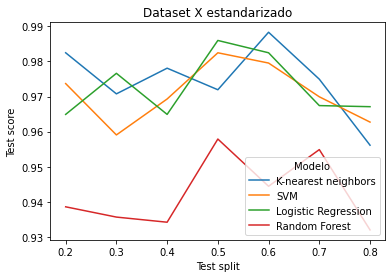


El mejor modelo es K-nearest neighbors con un puntaje de prueba de 0.9883




,Modelo,Train score,Test score,Parametros,Test split
16,K-nearest neighbors,0.938357,0.988304,{'n_neighbors': 8},0.6
14,Logistic Regression,0.968358,0.985965,"{'C': 0.1, 'solver': 'liblinear'}",0.5
13,SVM,0.968296,0.982456,"{'C': 0.1, 'kernel': 'linear'}",0.5
18,Logistic Regression,0.973720,0.982456,"{'C': 0.1, 'solver': 'liblinear'}",0.6
0,K-nearest neighbors,0.960440,0.982456,{'n_neighbors': 4},0.2


In [ ]:
sort_data = data_results['X norm'].sort_values(by=['Test score'], ascending=False)

sns.lineplot(data=data_results['X norm'], x='Test split', y='Test score', hue='Modelo')
plt.title("Dataset X estandarizado")
plt.show()

text = "\nEl mejor modelo es \033[1m{}\033[0m con un puntaje de prueba de \033[1m{}\033[0m\n\n"
print(text.format(sort_data.iloc[0,0], np.round(sort_data.iloc[0,2],4)))
sort_data.head()

- A comparación del caso anterior, el modelo de Random Forest es el que menor puntaje obtiene respecto a los otros tres clasificadores

- Tanto para los modelos: logistic regression, k-nearest neighbor y SVM, se observan comportamientos relativamente similares para las diferentes particiones de los datos evaluados.

- El mejor puntaje de prueba es de **0.988** obtenido para el modelo **K-nearest neighbor** con **n_neighbor: 8** y un 60% de los datos para prueba.

## **3. Reducción de atributos**

Evaluado lo anterior, se analizan tres formas de reducir la dimensionalidad de los atributos:

- Correlación
- Regresión
- Análisis univariado

Para cada una de las opciones se guarda un dataset para ser evaluado y conocer si el comportamiento para los modelos evaluados mejora o no

### **3.1. Correlación (X1)**

A continuación, se evalúa la correlación de los atributos

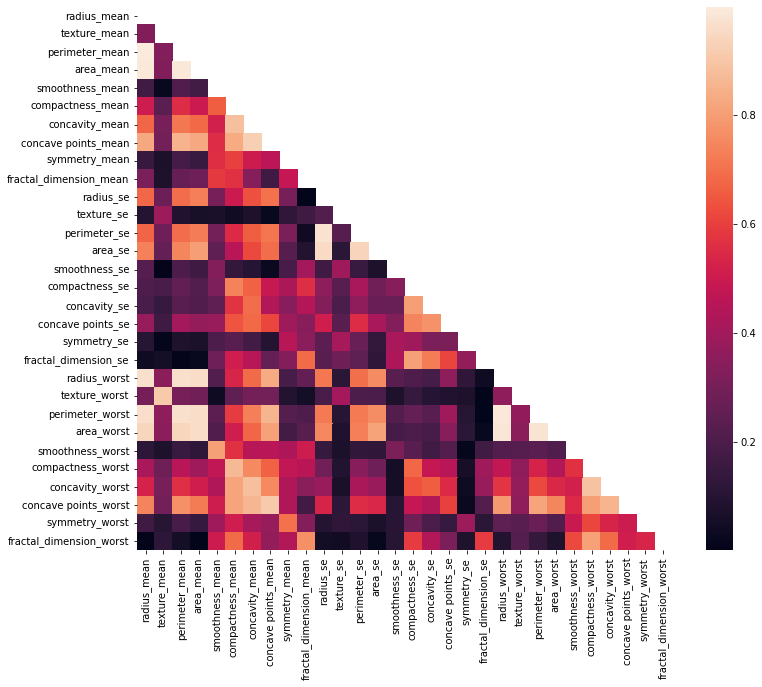

In [ ]:
corr_matrix = X_norm.corr().abs()
plt.figure(figsize=(12,10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
#cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, mask = mask)
plt.show()

Se observa que existen varios atributos con una correlación alta (mayor de 0.9). Se procede a eliminar estos y se guardan (***X1***) para posterior evaluación.

In [ ]:
columns_list = np.full((corr_matrix.shape[0],), True, dtype=bool)

# Umbral
threshold = 0.9

# Se extrae una de los dos atributos con correlacion mayor al umbral
for i in range(corr_matrix.shape[0]):
  for j in range(i+1, corr_matrix.shape[0]):
    if corr_matrix.iloc[i,j] >= threshold:
      if columns_list[j]:
        columns_list[j] = False

selected_columns = X_norm.columns[columns_list]
X1 = X_norm[selected_columns]

print("Los atributos eliminados son:\n")
for i in X_norm.columns:
  if not i in selected_columns:
    print(i)

print("\nX1 presenta {} atributos".format(X1.shape[1]))

Los atributos eliminados son:

perimeter_mean
area_mean
concave points_mean
perimeter_se
area_se
radius_worst
texture_worst
perimeter_worst
area_worst
concave points_worst

X1 presenta 20 atributos


Para este dataset (X1) **se eliminan 10 de los 30 atributos** iniciales

### **3.2. Regresión (X2)**

Se analiza la importancia de los atributos a partir de los coeficientes entregados por el modelo Lasso

In [ ]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(tol=1e-2, random_state=4).fit(X_norm, y)
importance = np.abs(lasso.coef_)
feature_names = np.array(X_norm.columns)

feats = {}

for feature, imp in zip(X_norm.columns, importance):
  feats[feature] = imp

# Serie con los atributos ordenados con mayor importancia
feats_serie = pd.Series(feats).sort_values(ascending=False)

# Se descartan los atributos con importancia menor a 0.01
feats_serie = feats_serie.loc[feats_serie.values > 0.01]
X2 = X_norm[feats_serie.index]

print("\nX2 presenta {} atributos".format(X2.shape[1]))


X2 presenta 21 atributos


Mediante este método **se eliminan 9 de los 30 atributos** según la magnitud de los coeficientes del modelo

### **3.3. Análisis univariado (X3)**

Ahora se seleccionan atributos en base a pruebas estadística univariadas. Se tiene en cuenta lo siguiente:

- Para **regresiones** se tienen las siguientes métricas: f_regression, mutual_info_regression

- Para **clasificación**: chi2, f_classif, mutual_info_classif

Ref: [univariate-feature-selection | sklearn](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection)


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

selector = SelectKBest(chi2, k=10).fit(X,y)
X3 = X_norm[X_norm.columns[selector.get_support()]]
print("\nX1 presenta {} atributos".format(X3.shape[1]))


X1 presenta 10 atributos


En este caso, se deciden escoger los 10 mejores atributos a partir del análisis Chi2

## **4. Evaluación de atributos**

Se evalúan los datasets (X1, X2, X3) a partir de un análisis exploratorio para conocer cual aporta mayor información y por ende puede llegar a mejorar la construcción del modelo definitivo.

In [ ]:
data_results_2 = {}
datasets = {'X1': X1, 'X2': X2, 'X3': X3}

for dataset in datasets:
  results = []
  feats = datasets[dataset]
  for size in data_split:
    # Se divide el dataset
    X_train, X_test, y_train, y_test = train_test_split(feats, y, test_size = size, random_state=4)

    model = []
    grid_score = []
    cross_score = []
    params = []

    for model_name, values in model_params.items():
      clf = GridSearchCV(values['model'], values['params'], cv=5)
      clf.fit(X_train, y_train)
      
      #test_score = cross_validate(clf.best_estimator_, X_test, y_test, scoring='accuracy', cv = 5)

      model.append(model_name)
      grid_score.append(clf.best_score_)
      #cross_score.append(np.mean(test_score['test_score']))
      cross_score.append(clf.score(X_test, y_test))
      params.append(clf.best_params_)

    dummy_df = pd.DataFrame({'Modelo': model, 'Train score': grid_score,
                            'Test score': cross_score, 'Parametros': params})
    dummy_df['Test split'] = np.round(size, 1)

    # Guarda los resultados para el Split respectivo
    results.append(dummy_df)

  # Resultados para el dataset respectivo
  data_results_2[dataset] = pd.concat([data for data in results ]).reset_index().drop('index', axis=1)

### **4.1. Dataset - X1**

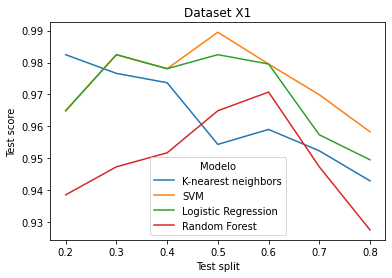


El mejor modelo es SVM con un puntaje de prueba de 0.9895




,Modelo,Train score,Test score,Parametros,Test split
13,SVM,0.961278,0.989474,"{'C': 0.1, 'kernel': 'linear'}",0.5
0,K-nearest neighbors,0.945055,0.982456,{'n_neighbors': 10},0.2
5,SVM,0.974810,0.982456,"{'C': 0.1, 'kernel': 'linear'}",0.3
6,Logistic Regression,0.969842,0.982456,"{'C': 0.1, 'solver': 'newton-cg'}",0.3
14,Logistic Regression,0.954323,0.982456,"{'C': 0.1, 'solver': 'newton-cg'}",0.5


In [ ]:
sort_data = data_results_2['X1'].sort_values(by=['Test score'], ascending=False)

sns.lineplot(data=data_results_2['X1'], x='Test split', y='Test score', hue='Modelo')
plt.title("Dataset X1")
plt.show()

text = "\nEl mejor modelo es \033[1m{}\033[0m con un puntaje de prueba de \033[1m{}\033[0m\n\n"
print(text.format(sort_data.iloc[0,0], np.round(sort_data.iloc[0,2],4)))
sort_data.head()

- Los modelos Logistic Regression y SVM presentan comportamientos similares hasta una proporción de 40% para prueba.

- Para el 50% de los datos para entrenamiento y prueba se observa el puntaje máximo de **0.989** para el modelo **SVM** con los parámetros **C: 0.1** y **kernel: linear**

### **4.2. Dataset - X2**

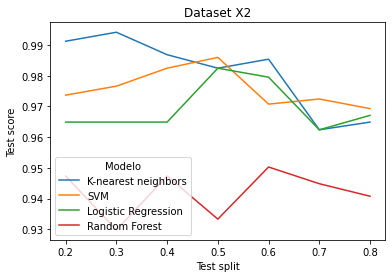


El mejor modelo es K-nearest neighbors con un puntaje de prueba de 0.9942




,Modelo,Train score,Test score,Parametros,Test split
4,K-nearest neighbors,0.959778,0.994152,{'n_neighbors': 16},0.3
0,K-nearest neighbors,0.962637,0.991228,{'n_neighbors': 12},0.2
8,K-nearest neighbors,0.961850,0.986842,{'n_neighbors': 10},0.4
13,SVM,0.975376,0.985965,"{'C': 0.1, 'kernel': 'linear'}",0.5
16,K-nearest neighbors,0.947053,0.985380,{'n_neighbors': 14},0.6


In [ ]:
sort_data = data_results_2['X2'].sort_values(by=['Test score'], ascending=False)

sns.lineplot(data=data_results_2['X2'], x='Test split', y='Test score', hue='Modelo')
plt.title("Dataset X2")
plt.show()

text = "\nEl mejor modelo es \033[1m{}\033[0m con un puntaje de prueba de \033[1m{}\033[0m\n\n"
print(text.format(sort_data.iloc[0,0], np.round(sort_data.iloc[0,2],4)))
sort_data.head()

- Para este conjunto de atributos el modelo que más resalta es **K-nearest neighbor** cuyo puntaje máximo es de **0.994** para **n_neighbor: 16** y un 30% de los datos para prueba.

### **4.3. Dataset - X3**

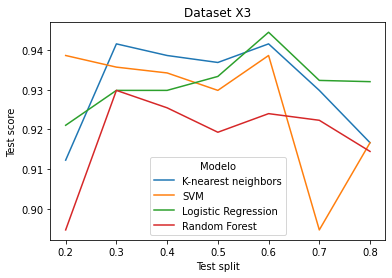


El mejor modelo es Logistic Regression con un puntaje de prueba de 0.9444




,Modelo,Train score,Test score,Parametros,Test split
18,Logistic Regression,0.951691,0.944444,"{'C': 1, 'solver': 'liblinear'}",0.6
4,K-nearest neighbors,0.939715,0.941520,{'n_neighbors': 24},0.3
16,K-nearest neighbors,0.951691,0.941520,{'n_neighbors': 14},0.6
17,SVM,0.951691,0.938596,"{'C': 1, 'kernel': 'linear'}",0.6
1,SVM,0.956044,0.938596,"{'C': 10, 'kernel': 'rbf'}",0.2


In [ ]:
sort_data = data_results_2['X3'].sort_values(by=['Test score'], ascending=False)

sns.lineplot(data=data_results_2['X3'], x='Test split', y='Test score', hue='Modelo')
plt.title("Dataset X3")
plt.show()

text = "\nEl mejor modelo es \033[1m{}\033[0m con un puntaje de prueba de \033[1m{}\033[0m\n\n"
print(text.format(sort_data.iloc[0,0], np.round(sort_data.iloc[0,2],4)))
sort_data.head()

- El puntaje máximo es de **0.944** y se obtiene para el modelo **Logistic Regression** con los parámetros **C: 1** y **solver: liblinear** con un 60% de los datos para prueba.

## **5. Modelo final**

A partir de la evaluación para cada uno de los dataset con los atributos reducidos, se elige el **conjunto X2**, el modelo **K-nearest neighbor** para **k = 16** y un **30% de los datos para prueba**.

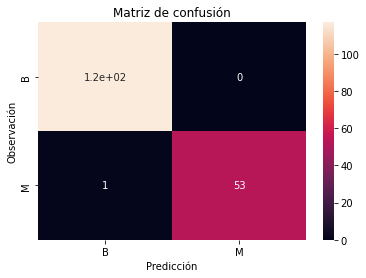


Exactitud = 0.9941520467836257
Precision = 0.9915254237288136
Recall = 1.0
F1-Score = 0.9957446808510638


In [ ]:
# Se divide el dataset
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size = 0.3, random_state=4)

# Entrenamiento del modelo y predicción
final_clf = KNeighborsClassifier(n_neighbors = 16).fit(X_train,y_train)
yhat=final_clf.predict(X_test)

# Matriz de confusión
matrix = pd.crosstab(le.inverse_transform(y_test), le.inverse_transform(yhat), 
                               rownames=['Observación'], colnames=['Predicción'])

sns.heatmap(matrix, annot=True)
plt.title("Matriz de confusión")
plt.show()

# Se obtienen la cuenta para cada condicion
TP_count = matrix.iloc[0]['B']
FN_count = matrix.iloc[0]['M']
FP_count = matrix.iloc[1]['B']
TN_count = matrix.iloc[1]['M']

exactitud = (TP_count + TN_count) / (TP_count + TN_count + FN_count + FP_count)
precision = (TP_count) / (TP_count + FP_count)
recall = (TP_count) / (TP_count + FN_count)
F1_score = (2*precision*recall) / (precision + recall)

print("\nExactitud = " + str(exactitud))
print("Precision = " + str(precision))
print("Recall = " + str(recall))
print("F1-Score = " + str(F1_score))

## **Conclusiones**

- El mejor se obtiene para un dataset con 21 de los 30 atributos iniciales obtenidos a través de un análisis de importancia por medio del modelo Lasso.

- El modelo final arroja una exactitud y F1-Score superior a 0.99 para el clasificador k-nearest neighbor con k = 16 y un 70% de los datos para entrenamiento. 

- Al momento de definir el número de k-vecinos más cercanos (n_neighbors) se debe tener en cuenta que este sea menor al número de observaciones de los datos de entrenamiento y validación (según la validación cruzada con GridSearchCV)

- En la selección de los atributos con el modelo Lasso se establece un umbral de 0.01 con el cual se deciden el número de columnas que se eliminan. Sin embargo, este valor se puede variar y evaluar la cantidad de atributos reducidos junto al comportamiento del modelo.

- De igual forma para el análisis univariado, se seleccionan los diez (10) atributos más importantes según la prueba Chi2. Sin embargo, en la evaluación se observa que es el conjunto de datos que menor puntaje obtiene. Esto puede ser a que la prueba estadística usada no es la más adecuada para el dataset o que al elegir solo 10 atributos se eliminan otros que contengan información de valor en el modelo.

# Links de interés

- [Correlation feature selection](https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf): blog sobre la selección de atributos según su correlación y valor P

- [Sklearn: Ensemble](https://scikit-learn.org/stable/modules/ensemble.html): distintos métodos de ensambles disponibles en sklearn

- [forest importances | sklearn](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html): análisis de la importancia de atributos a través del modelo RandomForest con sklearn